In [1]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
from IPython.display import Audio
import pandas as pd
from os import listdir
import math
from random import randint

In [2]:
#Function to listent to audios.

def listenAudio(data, samplerate = 16000):
    return Audio(data = data, rate = samplerate)

## Exploring the data

In [3]:
#Read all the audios with Librosa

X = []
sampleRates = []
paths = []
speakers = []

rootDir = './data/audio/speakers'
for speakerDir in listdir(rootDir):
    finalDir = rootDir + '/' + speakerDir
    for file in listdir(finalDir):
        x, sampleRate = librosa.load(finalDir + '/' + file, sr = None)
        sampleRates.append(sampleRate)
        X.append(x)
        paths.append('dsl_data/audio/speakers/'+speakerDir+'/'+file)
        speakers.append(speakerDir)

In [4]:
#Check how many audio in total
print('There are', len(X), 'audios')

There are 11309 audios


In [5]:
#Compute duration of the audio recordings
def durations(x, sr):
    return len(x)/sr

#audio durations before trimming
durationsBT = [durations(x, sr) for x, sr in zip (X, sampleRates)]

In [6]:
#store audios, sample rates, speaker, path and durationsBT in a dataframe

rawAudioDf = pd.DataFrame(list(zip(X, sampleRates, speakers, paths, durationsBT)), columns = ['x', 'sr', 'speaker', 'path', 'durationsBT'])

In [7]:
# listen some longer audios
longerAudiosix = rawAudioDf.sort_values(by = 'durationsBT', ascending = False ).index[:10]

index = longerAudiosix[0] 
listenAudio(rawAudioDf.iloc[index]['x'], rawAudioDf.iloc[index]['sr'])

#There are several seconds of silence at the end.

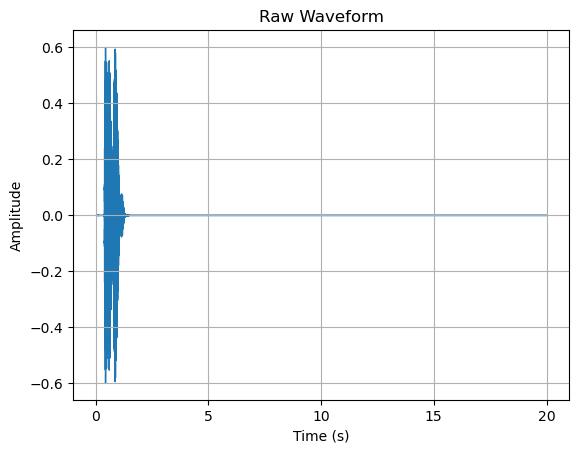

In [8]:
#Display the raw waveform in the time domain
librosa.display.waveshow(rawAudioDf.iloc[index]['x'], sr = rawAudioDf.iloc[index]['sr'], x_axis='s')
plt.title('Raw Waveform')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

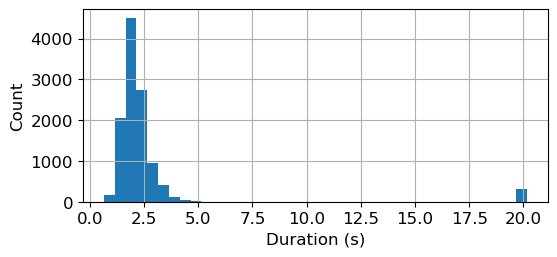

In [9]:
#function to plot histogram of durations
def plotDurations(durations):
    binwidth = 0.5
    fig, ax =  plt.subplots(figsize = (6,2.5))
    ax.hist(durations, bins=np.arange(min(durations), max(durations) + binwidth, binwidth))
    plt.xlabel('Duration (s)', fontsize = 12)
    plt.ylabel('Count', fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.grid()
    plt.show()

plotDurations(rawAudioDf['durationsBT'])

In [10]:
#compute mean duration
print('Mean duration:', np.mean(rawAudioDf['durationsBT']),'sec')

Mean duration: 2.5913703300467876 sec


In [11]:
#Check if 20 sec audios are all from the same speaker

print('Audios of lenght 20s:', len(rawAudioDf[rawAudioDf['durationsBT'] == 20 ]))
rawAudioDf[rawAudioDf['durationsBT'] == 20 ].value_counts('speaker')

#There are 300 audios that last 20 seconds, they are the only one with sr = 22050,
#They are from different speakers

Audios of lenght 20s: 300


speaker
mj4BWeRbp7ildyB9d    18
7NqqnAOPVVSKnxyv     16
8B9N9jOOXGUordVG     15
eBQAWmMg4gsLYLLa     14
DWNjK4kYDACjeEg3     10
                     ..
KLa5k73rZvSlv82X      1
9mYN2zmq7aTw4Blo      1
8e5qRjN7dGuovkRY      1
73bEEYMKLwtmVwV43     1
gvKeNY2D3Rs2jRdL      1
Length: 71, dtype: int64

### Trimming phase

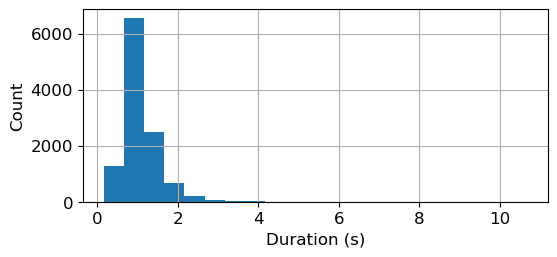

In [12]:
# Trim audios top_db = 20
X_trimmed = []
for x in X:
    X_trimmed.append(librosa.effects.trim(x, top_db = 20)[0])

#add trimmed audios and lenghts to df
rawAudioDf['xAT'] = X_trimmed
rawAudioDf['durationsAT'] = [durations(x, sr) for x, sr in zip (X_trimmed, sampleRates)]

plotDurations(rawAudioDf['durationsAT'])

In [13]:
#There are still some outliers, we decided to adjust them.
#After manual inspection we decide that cutting all the audios at maximum
#5 seconds will not make us lose important data

def manuallyCut(row):
    secMaxDuration = 5
    if row['durationsAT'] > secMaxDuration:
        maxSize = row['sr']*secMaxDuration
        return row['xAT'][:maxSize]
    else:
        return row['xAT']

rawAudioDf['xAMT'] = rawAudioDf.apply(manuallyCut, axis = 1)

#Recalculate duration
def recalcDuration(row):
    return len(row['xAMT'])/row['sr']

rawAudioDf['durationsAMT'] = rawAudioDf.apply(recalcDuration, axis = 1)

#show some longer audio
rawAudioDf.sort_values(by = 'durationsAT', ascending = False ).head(2)

,x,sr,speaker,path,durationsBT,xAT,durationsAT,xAMT,durationsAMT
9737,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",16000,xEYa2wgAQof3wyEO,dsl_data/audio/speakers/xEYa2wgAQof3wyEO/29e53...,13.226688,"[0.00012207031, 0.00021362305, 0.00024414062, ...",10.400,"[0.00012207031, 0.00021362305, 0.00024414062, ...",5.0
695,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",16000,5BEzPgPKe8taG9OB,dsl_data/audio/speakers/5BEzPgPKe8taG9OB/8160c...,8.080562,"[-0.00048828125, -0.00012207031, 0.0002746582,...",7.072,"[-0.00048828125, -0.00012207031, 0.0002746582,...",5.0


In [14]:
#Listen to some audio after trimming to check if no informations are lost
ix = randint(0, 11308)
listenAudio(rawAudioDf.iloc[ix]['xAMT'], rawAudioDf.iloc[ix]['sr'])

### Merge with data about speakers

In [15]:
devDf = pd.read_csv("./data/development.csv", index_col='Id')\
.set_axis(['path', 'speakerId', 'action', 'object', 'fluency', 'firstLanguage', 'currentUsedLanguage', 'gender', 'ageRange'], axis=1, inplace=False)

evaDf = pd.read_csv("./data/evaluation.csv", index_col='Id')\
.set_axis(['path', 'speakerId', 'fluency', 'firstLanguage', 'currentUsedLanguage', 'gender', 'ageRange'], axis=1, inplace=False)

#Create a df that contains both the evaluation and the development set
df = pd.concat([evaDf, devDf], sort=False)

#Label Creation
def labelCreation(df):
    df['label'] = df['action']+df['object']
    df.drop('action', inplace=True, axis=1)
    df.drop('object', inplace=True, axis=1)
    return df

df = labelCreation(df)

#It is important that the first rows are from the evaDf this way they will have
#the right index for the submission platform

explorativeDf = pd.merge(df, rawAudioDf, on = 'path')

### Exploring having the labels

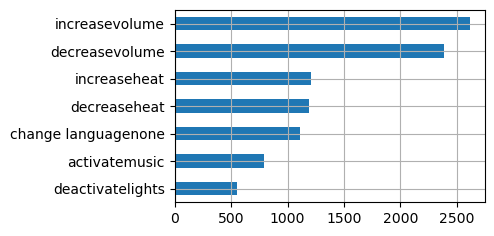

In [16]:
fig, ax = plt.subplots(figsize = (4,2.5))
ax = df.label.value_counts().sort_values().plot(kind = 'barh')
plt.grid()

In [17]:
#Hear at some random samples along with the label
ind = randint(0, 11308)
print(explorativeDf.iloc[ind]['label'])
listenAudio(explorativeDf.iloc[ind]['xAMT'], explorativeDf.iloc[ind]['sr'])

change languagenone


In [18]:
#Manually check if a person says the same label in the same way
explorativeDf[(explorativeDf.label == 'decreaseheat') & (explorativeDf.speakerId == 'zaEBPeMY4NUbDnZy')].sample()

,path,speakerId,fluency,firstLanguage,currentUsedLanguage,gender,ageRange,label,x,sr,speaker,durationsBT,xAT,durationsAT,xAMT,durationsAMT
9659,dsl_data/audio/speakers/zaEBPeMY4NUbDnZy/ef790...,zaEBPeMY4NUbDnZy,native,English (United States),English (United States),female,22-40,decreaseheat,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",16000,zaEBPeMY4NUbDnZy,2.730688,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.44,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.44


In [19]:
ind = 9657
print(explorativeDf.iloc[ind]['label'])
listenAudio(explorativeDf.iloc[ind]['xAMT'], explorativeDf.iloc[ind]['sr'])

decreaseheat


### Exploring lenghts with the labels

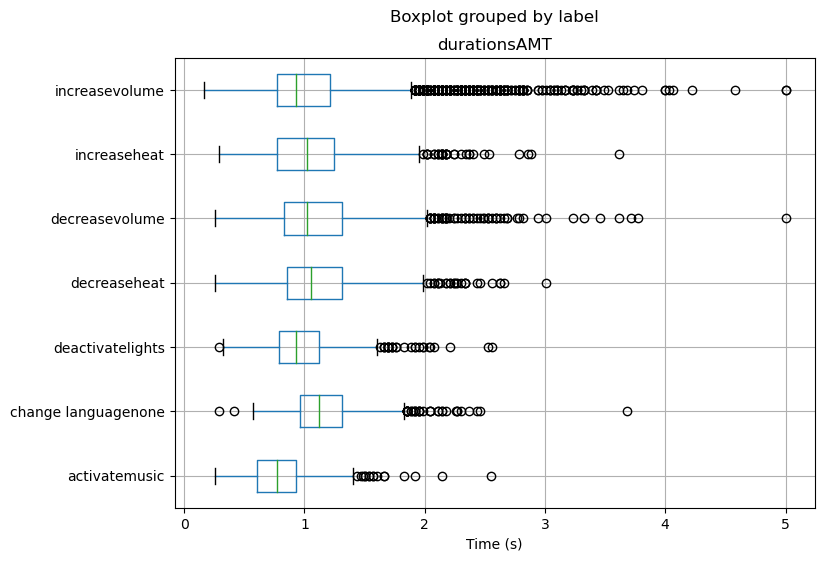

In [20]:
#Boxplot of Duration after additional manual trimming
explorativeDf.boxplot(column = 'durationsAMT', by = 'label', vert = False,figsize= (8,6))
plt.xlabel('Time (s)')
plt.show()

# Extracting features
## From speakers' attributes

In [21]:
#Ordinal features
def preProcOrdinal(df):
    df['ageRange'].replace(['22-40', '41-65','65+'], [0, 1, 2], inplace=True)
    df['fluency'].replace(['basic', 'intermediate', 'advanced', 'native'], [0,1,2,3], inplace = True)


#Categorical Features
def oheCategorical(df):
    df.drop('firstLanguage', inplace=True, axis=1)
    df.drop('speakerId', inplace=True, axis=1)
    df.drop('currentUsedLanguage', inplace=True, axis=1)
    return pd.get_dummies(df, columns=['gender'])

midDf = explorativeDf.copy()
preProcOrdinal(midDf)
midDf = oheCategorical(midDf)
#midDf.head()

## From Audio

In [22]:
#Extract xAMT
XAMT = midDf['xAMT'].values

#Extract sample rates so that they are ordered
orderedSr = midDf['sr'].values

#Extract paths so that they are ordere
orderedPaths = midDf['path'].values

### MFCC

In [23]:
#Extract mean from each mfcc coefficient
def mfccExraction(x, sr):
    # Extract row mean Mel-frequency cepstral coefficients (MFCCs)
    mfccs = np.mean(librosa.feature.mfcc(y=x, sr=sr,n_mfcc=13), axis=1)
    return mfccs

X_mfcc = [mfccExraction(x, sr) for x, sr in zip(XAMT, orderedSr)]

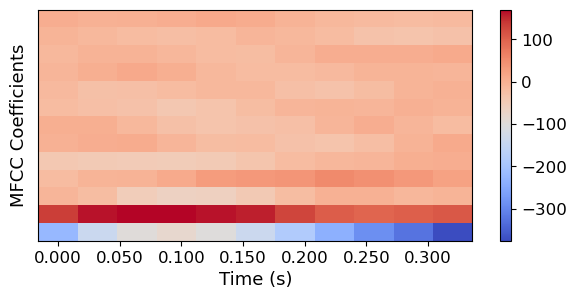

In [24]:
#Compute and visualize mfcc for an audio
mfccs = librosa.feature.mfcc(y=XAMT[2000], sr=orderedSr[2000], n_mfcc=13)
fig, ax = plt.subplots(figsize = (7, 3))
ax = librosa.display.specshow(mfccs, x_axis = 'time', sr=orderedSr[12])
plt.xlabel('Time (s)', fontsize = 13)
plt.ylabel('MFCC Coefficients', fontsize = 13)
plt.xticks(fontsize = 12)
cbar = plt.colorbar()
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(12)

plt.show()

### Mel Spectrogram

In [25]:
#get Mel Spectrogram
def getMelSpectDb(y, sr):
    n_fft=512
    hop_length=320
    mel_bins = 40 # Number of mel bands
    fmin = 0
    fmax= None
    Mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, win_length=n_fft, n_mels = mel_bins, power=2.0)
    mel_spectrogram_db = librosa.power_to_db(Mel_spectrogram, ref=np.max)
    return mel_spectrogram_db

XmelDb = [getMelSpectDb(y, sr) for y, sr in zip(XAMT, orderedSr)]

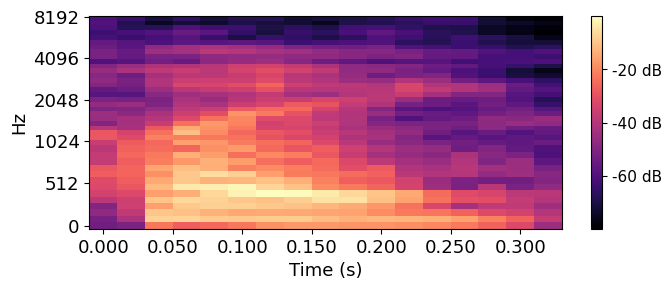

In [26]:
#Visualize Mel Spectrogram
fig, ax = plt.subplots(figsize = (7, 3))
ax = librosa.display.specshow(XmelDb[2000], sr=orderedSr[2000], x_axis='time', y_axis='mel', hop_length=320)
#plt.colorbar(format='%+2.0f dB')
plt.xlabel('Time (s)', fontsize = 13)
plt.ylabel('Hz', fontsize = 13)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
cbar = plt.colorbar(format='%+2.0f dB')
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(11)
plt.tight_layout()
plt.show()

In [27]:
#get the average for each block of the mel matrix
def nsqMeansFromMatrix(matrix, n):
    res = np.zeros(n**2)
    vertSize = math.ceil(matrix.shape[0]/n)
    horSize = math.ceil(matrix.shape[1]/n)
    k = 0
    for i in range(0, matrix.shape[0], vertSize):
        for j in range(0, matrix.shape[1], horSize):
            res[k] = np.mean(matrix[i:i+vertSize, j:j+horSize])
            k = k+1
            #print(matrix[i:i+vertSize, j:j+horSize], np.mean(matrix[i:i+vertSize, j:j+horSize]))
    return res

#get the standard deviation for each block of the mel matrix
def nsqStdFromMatrix(matrix, n):
    res = np.zeros(n**2)
    vertSize = math.ceil(matrix.shape[0]/n)
    horSize = math.ceil(matrix.shape[1]/n)
    k = 0
    for i in range(0, matrix.shape[0], vertSize):
        for j in range(0, matrix.shape[1], horSize):
            res[k] = np.std(matrix[i:i+vertSize, j:j+horSize])
            k = k + 1
            #print(matrix[i:i+vertSize, j:j+horSize], np.std(matrix[i:i+vertSize, j:j+horSize]))
    return res

## Preprocessing tuning: n

In [28]:
#Creates 10 dfs with differen numbers of mean and std and append them in allDfs

allDfs = []
for n in range(2, 21, 2):
    XMeans = [nsqMeansFromMatrix(mat, n) for mat in XmelDb]
    X_std =  [nsqMeansFromMatrix(mat, n) for mat in XmelDb]
    
    #Concatenate all audio features
    XMeanMfccStd = [np.concatenate((x_mean, x_mfcc, x_std)) for x_mean, x_mfcc, x_std in zip(XMeans, X_mfcc, X_std)]
    
    #Create a dataframe with path as index
    diz = dict()
    for path, x in zip(orderedPaths, XMeanMfccStd):
        diz[path] = x

    audioDf = pd.DataFrame(diz).transpose()
    audioDf['path'] = audioDf.index
    
    #merge midDf with the just built df
    finalDf = pd.merge(midDf, audioDf, on = 'path')
    
    #Remove columns that are not used as features
    toRemove = ['path', 'x', 'sr', 'speaker', 'durationsBT', 'xAT', 'durationsAT', 'xAMT']
    finalDf.drop(toRemove, inplace = True, axis = 1)
    
    #store finalDf
    allDfs.append(finalDf)

In [29]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

rfClf = RandomForestClassifier()
pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC())])

csvRfClfs = []
csvPipes = []

stratKFold = StratifiedKFold(n_splits=5, shuffle=True, random_state = 42)

for testedDf in allDfs:
    train_valid_mask = ~testedDf["label"].isna()
    X = testedDf.drop(columns = ['label']).values
    y = testedDf['label'].values
    X_train_valid = X[train_valid_mask]
    y_train_valid = y[train_valid_mask]
    csvRfClfs.append(cross_val_score(rfClf, X_train_valid, y_train_valid, scoring = 'accuracy', cv = stratKFold))
    csvPipes.append(cross_val_score(pipe, X_train_valid, y_train_valid, scoring = 'accuracy', cv = stratKFold))

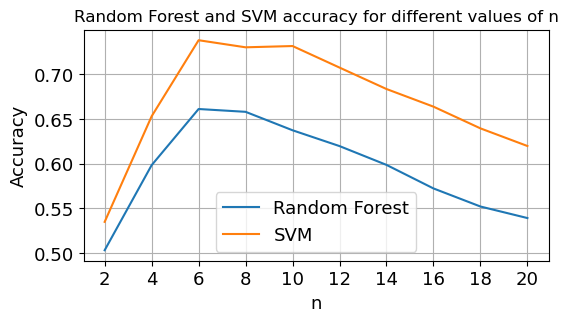

In [30]:
#Compute means
meanAccsRf = [np.mean(cvsRf) for cvsRf in csvRfClfs]
meanACCsSVC = [np.mean(cvsPi) for cvsPi in csvPipes]

#Plot means
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(range(2,21,2), meanAccsRf, label = 'Random Forest')
ax.plot(range(2,21,2), meanACCsSVC, label = 'SVM')
plt.xticks(ticks = range(2,21,2), fontsize = 13)
plt.yticks(fontsize = 13)
plt.xlabel('n', fontsize = 13)
plt.ylabel('Accuracy', fontsize = 13)
plt.legend(fontsize = 13)
plt.title('Random Forest and SVM accuracy for different values of n')
plt.grid()
plt.show()

## Models hyperparameter tuning
### Random Forest

In [31]:
#Divide the dataset with the best preprocessing in train_val(development set) and test (evaluation set)

#Choose the dataframe with the best preprocessing
indexBestDf = 2
train_valid_mask = ~allDfs[indexBestDf]["label"].isna()

X = allDfs[indexBestDf].drop(columns = ['label']).values
y = allDfs[indexBestDf]['label'].values

X_train_valid = X[train_valid_mask]
y_train_valid = y[train_valid_mask]

X_test = X[~train_valid_mask] #X and y test dfs mantain their original index
y_test = y[~train_valid_mask]

In [32]:
from sklearn.model_selection import GridSearchCV

param_gridRf = {'n_estimators': [300],
                'max_depth': [None, 2, 5, 10, 50],
                'criterion' : ['gini', 'entropy']
             }

stratKFold = StratifiedKFold(n_splits=5, shuffle=True, random_state = 0)

clfRF = RandomForestClassifier()
gridRf = GridSearchCV(estimator = clfRF, param_grid = param_gridRf, scoring = 'accuracy', refit = True, verbose = 1)

# fitting the model for grid search
gridRf.fit(X_train_valid, y_train_valid)

# print best parameter after tuning
print(gridRf.best_params_)
  
# print how our model looks after hyper-parameter tuning
print(gridRf.best_estimator_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'criterion': 'entropy', 'max_depth': None, 'n_estimators': 300}
RandomForestClassifier(criterion='entropy', n_estimators=300)


Find Random Forest accuracy with cross_val with the best parameters

In [33]:
#A different random state for the testing folds
stratKFold1 = StratifiedKFold(n_splits=5, shuffle=True, random_state = 1)

rfcvsClf = RandomForestClassifier(criterion='entropy', max_depth=50, n_estimators=300)
np.mean(cross_val_score(rfcvsClf, X_train_valid, y_train_valid, scoring = 'accuracy', cv = stratKFold1))

0.6846975561891075

## SVM

In [34]:
# defining parameter range
param_gridSVC = {'svc__C': [0.1, 1, 5, 10, 50, 100, 500, 1000], 
              'svc__kernel': ['rbf', 'sigmoid']}

#Feature Scaling
pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC())])

stratKFold = StratifiedKFold(n_splits=5, shuffle=True, random_state = 1)

In [35]:
gridSVC6 = GridSearchCV(pipe, param_gridSVC, scoring = 'accuracy',
                       cv = stratKFold, refit = True, verbose = 1)

# fitting the model for grid search
gridSVC6.fit(X_train_valid, y_train_valid)

# print best parameter after tuning
print(gridSVC6.best_params_)
  
# print how our model looks after hyper-parameter tuning
print(gridSVC6.best_estimator_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
{'svc__C': 10, 'svc__kernel': 'rbf'}
Pipeline(steps=[('scaler', StandardScaler()), ('svc', SVC(C=10))])


Find SVM accuracy with cross_val with the best parameters

In [36]:
svmPipe = Pipeline(steps=[('scaler', StandardScaler()), ('svc', SVC(C=10))])
np.mean(cross_val_score(svmPipe, X_train_valid, y_train_valid, scoring = 'accuracy', cv = stratKFold1))

0.8026186815422612

## Predict Evaluation and return csv

In [37]:
y_test = gridSVC6.predict(X_test)

In [110]:
to_csv = pd.Series(y_test, name = 'Predicted')
to_csv.index.names = ['Id']
to_csv.to_csv('provaSubmissionC10n6.csv')